In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\shinj\anaconda3\envs\ML\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
data = pd.read_csv(r'D:/shinj/Data/[1]pred-bitcoin/Data/bitcoin.csv') 
data.head() 

,Date,Open,High,Low,Close,Volume,Market Cap
0,29-Apr-13,134,147,134,145,0,1603768865
1,30-Apr-13,144,147,134,139,0,1542813125
2,01-May-13,139,140,108,117,0,1298954594
3,02-May-13,116,126,92,105,0,1168517495
4,03-May-13,106,108,79,98,0,1085995169


In [3]:
high_prices = data['High'].values 
low_prices = data['Low'].values 
mid_prices = (high_prices + low_prices) / 2 

In [4]:
#윈도우생성
seq_len = 50 #윈도우사이즈 50(50일의 데이터를 확인후 다음날짜 예측)
sequence_length = seq_len + 1 #50일+1(다음날짜)

result = [] #result변수에 51개씩 저장
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [5]:
#데이터 정규화
def normalize_windows(data):
    normalized_data = []
    
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        #첫번째 윈도우값0 기준,(현재날짜/이전날짜)-1
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result) #정규화 결과값 저장

#데이터가 부족함으로 학습데이터0.9 테스트데이터 0.1
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]

np.random.shuffle(train) 

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((2361, 50, 1), (262, 50, 1))

In [10]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1), stateful=False)) #stateful=False <- 배치안에서 시계열성 보장

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [22]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
#트레이닝
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10, 
    epochs=30, 
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_btc.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=5, verbose=1, mode='auto')
])

Epoch 1/30
237/237 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00001: val_loss improved from inf to 0.00073, saving model to ./models\2020_10_05_10_28_11_btc.h5
237/237 [==============================] - 6s 27ms/step - loss: 0.0049 - val_loss: 7.2529e-04
Epoch 2/30
237/237 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00002: val_loss did not improve from 0.00073
237/237 [==============================] - 5s 22ms/step - loss: 0.0049 - val_loss: 7.2529e-04
Epoch 3/30
235/237 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00003: val_loss did not improve from 0.00073
237/237 [==============================] - 5s 22ms/step - loss: 0.0049 - val_loss: 7.2529e-04
Epoch 4/30
236/237 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 00004: val_loss did not improve from 0.00073
237/237 [==============================] - 5s 22ms/step - loss: 0.0049 - val_loss: 7.2529e-04
Epoch 5/30
237/237 [==============================] - ETA: 

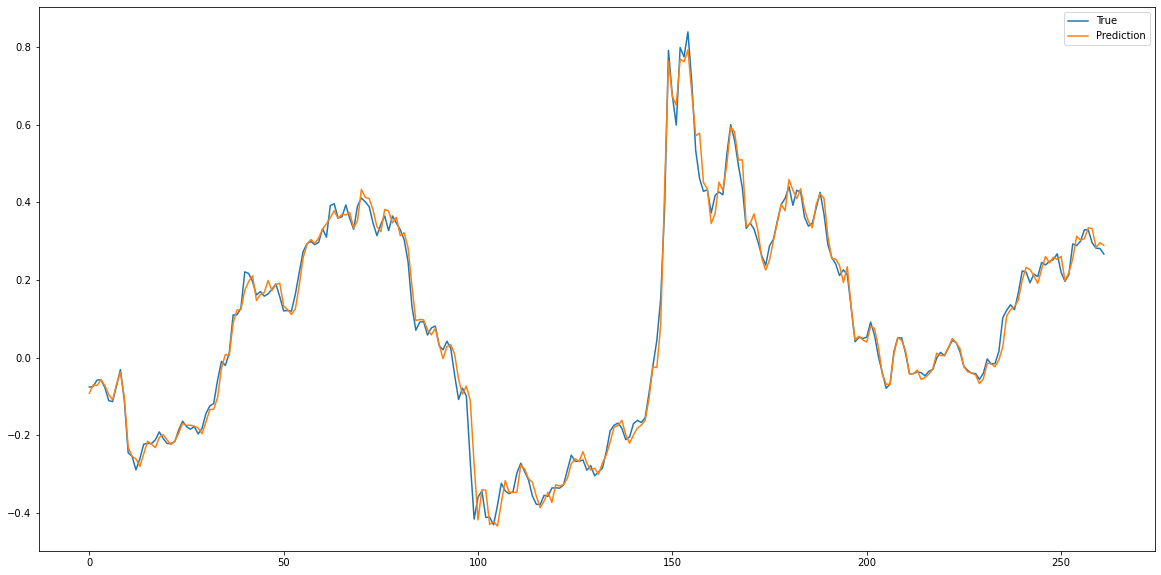

In [23]:
#검증및 가시화
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()